In [34]:
import os
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt


from collections import Counter
from sklearn.svm import SVC, OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

In [3]:
features = "mfcc_40_features"

with open(f"../../data/extracted_features/mfcc_stats_that_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)


for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

reader: 1069 | # samples 73
reader: 201 | # samples 79
reader: 311 | # samples 105
reader: 3240 | # samples 85
reader: 4297 | # samples 107
reader: 7800 | # samples 103
reader: 87 | # samples 103


In [4]:
def get_lowest_data(mfcc_dict):
    number_of_samples = []
    for reader in mfcc_dict.keys():
        number_of_samples.append(len(mfcc_dict[reader]))
    
    return min(number_of_samples)

def partition_data(reader, max, split=.8):
    mfccs = [mfcc for mfcc, _ in reader]
    mfccs = mfccs[0:max]

    mfccs_train = mfccs[0:round(len(mfccs)*split)]
    mfccs_test  = mfccs[round(len(mfccs)*split):len(mfccs)]

    return mfccs_train, mfccs_test

def partition_data_no_split(reader, max):
    mfccs = [mfcc for mfcc, _ in reader]
    mfccs = mfccs[0:max]

    return mfccs

def separate_labels(labels, speaker_keys):
    separated_labels = []
    current_index = 0
    for key in speaker_keys:
        separated_labels.append(labels[current_index:current_index+key])
        current_index += key
    return(separated_labels)

def calculate_percentage(data):
    percentages = []
    for sublist in data:
        total_count = len(sublist)
        if total_count == 0:
            percentages.append({})
            continue
        
        count_dict = {}
        for num in sublist:
            count_dict[num] = count_dict.get(num, 0) + 1
        
        percentage_dict = {num: (count / total_count) * 100 for num, count in count_dict.items()}
        percentages.append(percentage_dict)
    
    return percentages

def format_percentages(percentages):
    for i, percentage_dict in enumerate(percentages):
        if not percentage_dict:
            print(f"Sublist {i + 1}: No data")
            continue
        
        # Sort by percentage in descending order
        sorted_percentages = sorted(percentage_dict.items(), key=lambda x: x[1], reverse=True)
        
        # Format and print each sublist
        formatted_str = f"Speaker {i + 1}:\n\t" + ", ".join(
            f"{num}: {percent:.2f}%" for num, percent in sorted_percentages
        )
        print(formatted_str)

def create_truth_list(samples, label_order):
    """
    label_order: 
        0 for 1st half 0 and 2nd half 1
        1 for 1st half 1 and 2nd half 0
    """
    if label_order == 0:
        first_half  = [0 for _ in range(0, samples//2)]
        second_half = [1 for _ in range(0, samples//2)]        
    elif label_order == 1:
        first_half  = [1 for _ in range(0, samples//2)]
        second_half = [0 for _ in range(0, samples//2)]
    else:
        print("use 0 or 1")
    
    first_half.extend(second_half)
    return first_half

def create_binary_labels(length):
    return [(0 if i<length else 1) for i in range(0,2*length)]

In [5]:
def average_score(model,test_data):
    scores = []
    for data_point in test_data:
        scores.append(model.score(data_point.reshape(1,-1)))
    return scores, np.mean(scores)

def average_score_compare(model_dict, test_data_dict):
    for model_key in model_dict.keys():
        score_list = []
        for data_key in test_data_dict.keys():
            _, avg_score = average_score(model_dict[model_key], test_data_dict[data_key])
            avg_score = round(float(avg_score), 3)
            score_list.append((data_key, avg_score))
        print(f"model {model_key}: {score_list}")

def concatenate_with_key_first(dictionary, key):
    # Check if the key exists in the dictionary
    if key not in dictionary:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    # Get the list corresponding to the key
    key_list = dictionary[key]
    
    # Concatenate the key's list with all other lists
    result = key_list.copy()  # Start with the list for the specified key
    for k, v in dictionary.items():
        if k != key:  # Skip the list that corresponds to the key
            result.extend(v)  # Add the other lists
    
    return result, len(key_list)

def generate_metrics(model_dict, data_dict, key):
    """
    Returns metrics for One-Class SVM using predict():
    - [TP, FP
       FN, TN].
    """
    
    model = model_dict[key]
    control_data = data_dict[key]

    # Concatenate data (assuming the data_dict is structured similarly to the original code)
    data, segments_length = concatenate_with_key_first(data_dict, key)

    # Ground truth: first part is non-target (0), second part is target (1)
    ground_truth = [0] * segments_length + [1] * (len(data) - segments_length)
    
    # Get binary predictions (1 for inliers, -1 for outliers)
    predicted_labels = model.predict(data)

    # Convert predictions to binary labels: 1 for inliers, 0 for outliers
    predicted_labels = [1 if label == 1 else 0 for label in predicted_labels]

    # Generate confusion matrix and other metrics
    matrix = confusion_matrix(ground_truth, predicted_labels)
    accuracy = accuracy_score(ground_truth, predicted_labels)
    precision = precision_score(ground_truth, predicted_labels)
    recall = recall_score(ground_truth, predicted_labels)
    f1 = f1_score(ground_truth, predicted_labels)
    
    # For ROC AUC, we use the decision function to get the scores
    decision_scores = model.decision_function(data)
    roc_auc = roc_auc_score(ground_truth, decision_scores)
    fpr, tpr, _ = roc_curve(ground_truth, decision_scores)

    return matrix, accuracy, precision, recall, f1, roc_auc, fpr, tpr

def save_metrics(model_dict, data_dict, output_file="./metrics.txt"):
    metric_dict = {}
    
    for key in model_dict.keys():
        matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)

        if isinstance(matrix, np.ndarray):
            matrix = matrix.tolist()

        metric_dict[key] = {
            # 'threshold' : threshold,
            'matrix': matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

    with open(output_file, 'w') as f:
        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            # f.write(f"    threshold: {round(metrics['threshold'], 4)}\n")
            f.write(f"    accuracy: {round(metrics['accuracy'], 4)}\n")
            f.write(f"    precision: {round(metrics['precision'], 4)}\n")
            f.write(f"    recall: {round(metrics['recall'], 4)}\n")
            f.write(f"    F1-score: {round(metrics['f1'], 4)}\n")
            f.write(f"    ROC AUC: {round(metrics['roc_auc'], 4)}\n")
            
            # Formatting the matrix
            f.write(f"    matrix:\n")
            for row in metrics['matrix']:
                f.write(f"        {row}\n")
            f.write("\n")

    return metric_dict

def plot_roc_all(model_dict, data_dict, features_used="", save_dir=None):
    for key in model_dict.keys():
        _, _, _, _, _, roc_auc, fpr, tpr, = generate_metrics(model_dict, data_dict, key)
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models {features_used}')
    plt.legend(loc="lower right")

    if save_dir:    
        plt.savefig(os.path.join(save_dir, f"{features_used}.png"))
    plt.show()
    plt.close()

def compare_two_models(model_a, model_b, test_a, test_b):
    pass

In [84]:
def train_svm(train_dict, key):
    training_data, segments_length = concatenate_with_key_first(train_dict, key)
    training_data = np.vstack(training_data)
    ground_truth = [0] * segments_length + [1] * (len(training_data) - segments_length)
    model = SVC(kernel='rbf', C=1.0, gamma='scale')
    return(model.fit(training_data, ground_truth))

In [85]:
max_num_samples = 79

train_87_f, test_87_f = partition_data(mfcc_stats_dict["87"], max_num_samples)
train_4297_f, test_4297_f = partition_data(mfcc_stats_dict["4297"], max_num_samples)
train_7800_f, test_7800_f = partition_data(mfcc_stats_dict["7800"], max_num_samples)

train_201_m, test_201_m = partition_data(mfcc_stats_dict["201"], max_num_samples)
train_311_m, test_311_m = partition_data(mfcc_stats_dict["311"], max_num_samples)
train_3240_m, test_3240_m = partition_data(mfcc_stats_dict["3240"], max_num_samples)

test_data = {"87_f"   : test_87_f,
             "4297_f" : test_4297_f,
             "7800_f" : test_7800_f,
             "201_m"  : test_201_m,
             "311_m"  : test_311_m,
             "3240_m" : test_3240_m
             }

train_data = {"87_f"  : train_87_f,
             "4297_f" : train_4297_f,
             "7800_f" : train_7800_f,
             "201_m"  : train_201_m,
             "311_m"  : train_311_m,
             "3240_m" : train_3240_m
             }

speaker_87_model_f = train_svm(train_data, "87_f")
speaker_4297_model_f = train_svm(train_data, "4297_f")
speaker_7800_model_f = train_svm(train_data, "7800_f")

speaker_201_model_m = train_svm(train_data, "201_m")
speaker_311_model_m = train_svm(train_data, "311_m")
speaker_3240_model_m = train_svm(train_data, "3240_m")

speaker_models = {"87_f"   : speaker_87_model_f,
                  "4297_f" : speaker_4297_model_f,
                  "7800_f" : speaker_7800_model_f,
                  "201_m"  : speaker_201_model_m,
                  "311_m"  : speaker_311_model_m,
                  "3240_m" : speaker_3240_model_m
                  }

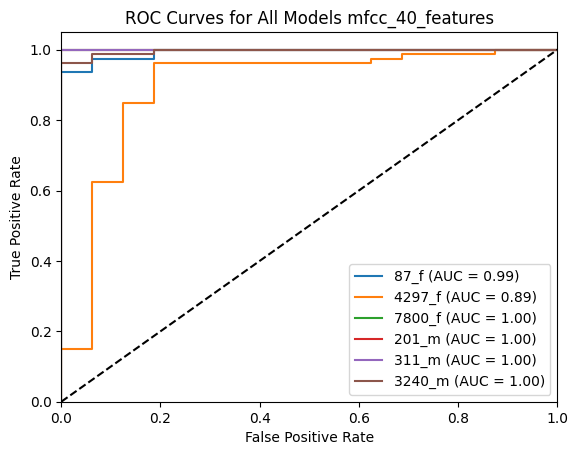

In [94]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/svm/{features}.txt")
plot_roc_all(speaker_models, test_data, features_used=features, save_dir="./metrics/svm/plots/")

In [ ]:
max_num_samples = 79

data_87_f = partition_data_no_split(mfcc_stats_dict["87"], max_num_samples)
data_4297_f = partition_data_no_split(mfcc_stats_dict["4297"], max_num_samples)
data_7800_f = partition_data_no_split(mfcc_stats_dict["7800"], max_num_samples)

data_201_m = partition_data_no_split(mfcc_stats_dict["201"], max_num_samples)
data_311_m = partition_data_no_split(mfcc_stats_dict["311"], max_num_samples)
data_3240_m = partition_data_no_split(mfcc_stats_dict["3240"], max_num_samples)

# test_data = {"87_f"   : test_87_f,
#              "4297_f" : test_4297_f,
#              "7800_f" : test_7800_f,
#              "201_m"  : test_201_m,
#              "311_m"  : test_311_m,
#              "3240_m" : test_3240_m
#              }

# train_data = {"87_f"  : train_87_f,
#              "4297_f" : train_4297_f,
#              "7800_f" : train_7800_f,
#              "201_m"  : train_201_m,
#              "311_m"  : train_311_m,
#              "3240_m" : train_3240_m
#              }

data = np.vstack([data_87_f, data_4297_f, data_7800_f, data_201_m, data_311_m, data_3240_m])
segments_length = len(data_87_f)

binary_labels = [0] * segments_length + [1] * (len(data) - segments_length)
# print(binary_labels)
data_train, data_test, label_train, label_test = train_test_split(data, binary_labels, test_size=0.2, random_state=42)



svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(data_train, label_train)

test_predictions = svm_model.predict(data_test)
accuracy = accuracy_score(label_test, test_predictions)
confusion_mat = confusion_matrix(label_test, test_predictions)

print(accuracy)
print(confusion_mat)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [57]:
print(len(data_87_f))
print(len(data_4297_f))

data = np.vstack([data_87_f, data_4297_f])

print(len(data))

# segments_length = len(data_87_f)

binary_labels = [0] * 79 + [1] * 79

count_ones = binary_labels.count(1)
count_zeros = binary_labels.count(0)

print("Number of 1s:", count_ones)
print("Number of 0s:", count_zeros)

print(binary_labels)
data_train, data_test, label_train, label_test = train_test_split(data, binary_labels, test_size=0.2, random_state=42)
print(len(label_test))


count_ones = label_test.count(1)
count_zeros = label_test.count(0)

print("Number of 1s:", count_ones)
print("Number of 0s:", count_zeros)


svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(data_train, label_train)

test_predictions = svm_model.predict(data_test)
accuracy = accuracy_score(label_test, test_predictions)
tn, fp, fn, tp = confusion_matrix(label_test, test_predictions).ravel()

print(accuracy)

print(f"tn {tn}")
print(f"fp {fp}")
print(f"fn {fn}")
print(f"tp {tp}")



79
79
158
Number of 1s: 79
Number of 0s: 79
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
32
Number of 1s: 17
Number of 0s: 15
0.90625
tn 15
fp 0
fn 3
tp 14
